# Auto scout project Balint Part 2: dealing with missing values

In [438]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [439]:
# load in the cleaned data 
df = pd.read_csv('data/clean_auto_scout.csv')

In [440]:
df.head()

,make_model,price,previous_owners_cleaned,co2emission_cleaned_gco2/km,emissionlabel_cleaned,emissionclass_cleaned,body_cleaned,bodycolor_cleaned,km_cleaned,vat_cleaned,...,led_headlights,lane_departure_warning_system,passenger-side_airbag,power_steering,rear_airbag,side_airbag,tire_pressure_monitoring_system,traction_control,traffic_sign_recognition,xenon_headlights
0,Audi A1,15770,2.0,992.0,NaN,6,Sedans,Black,56013.0,VAT deductible,...,0,0,1,1,0,1,1,1,0,1
1,Audi A1,14500,NaN,1292.0,Green,6,Sedans,Red,80000.0,Price negotiable,...,0,0,1,1,0,1,1,1,0,1
2,Audi A1,14640,1.0,992.0,Green,6,Sedans,Black,83450.0,VAT deductible,...,0,0,1,1,0,1,1,1,0,0
3,Audi A1,14500,1.0,992.0,NaN,6,Sedans,Brown,73000.0,NaN,...,0,0,1,1,0,1,1,0,0,0
4,Audi A1,16790,1.0,1092.0,NaN,6,Sedans,Black,16200.0,NaN,...,0,0,1,1,0,1,1,1,0,1


In [441]:
dict(df.isna().sum())

{'make_model': np.int64(0),
 'price': np.int64(0),
 'previous_owners_cleaned': np.int64(6665),
 'co2emission_cleaned_gco2/km': np.int64(2436),
 'emissionlabel_cleaned': np.int64(11974),
 'emissionclass_cleaned': np.int64(3628),
 'body_cleaned': np.int64(60),
 'bodycolor_cleaned': np.int64(597),
 'km_cleaned': np.int64(1024),
 'vat_cleaned': np.int64(4513),
 'registration_cleaned': np.int64(1597),
 'hp_kw_cleaned': np.int64(88),
 'nextinspection_cleaned': np.int64(15209),
 'type_cleaned': np.int64(2),
 'fuel_cleaned': np.int64(0),
 'particulate_filter': np.int64(0),
 'multiple_fuel': np.int64(0),
 'offernumber_cleaned': np.int64(3175),
 'warranty_months': np.int64(11066),
 'painttype_cleaned': np.int64(5772),
 'interior_material': np.int64(4503),
 'interior_colour': np.int64(5078),
 'nrofdoors_cleaned': np.int64(212),
 'nrofseats_cleaned': np.int64(977),
 'modelcode_cleaned': np.int64(10941),
 'gearingtype_cleaned': np.int64(0),
 'gears_cleaned': np.int64(4712),
 'cylinders_cleaned': np

## General strategy: find colinear variables and groupby these, calculate some average on the variable to fill 

## Registration cleaned - generate age column

In [442]:
# Extract year info to determine cars age
df['registration_cleaned'] = pd.to_datetime(df['registration_cleaned']) # convert to datetime type,looks like i did this already in part1, maybe converting to csv loses this
df['year'] = df['registration_cleaned'].dt.year
df['year'].value_counts()
df.drop('registration_cleaned', axis = 1, inplace = True)

In [443]:
# Generate 'age' column where 2019 is new (age = 0)
# Define the mapping of year to age
year_to_age = {
    2019: 0,
    2018: 1,
    2017: 2,
    2016: 3
}
# Use map() to apply the mapping
df['age'] = df['year'].map(year_to_age)
df['age'].value_counts(dropna = False)

age
1.0    4522
3.0    3674
2.0    3273
0.0    2853
NaN    1597
Name: count, dtype: int64

In [444]:
df.non_enc_cols = df[['make_model',
'previous_owners_cleaned',
 'co2emission_cleaned_gco2/km',
 'emissionlabel_cleaned',
 'emissionclass_cleaned',
 'body_cleaned',
 'bodycolor_cleaned',
 'km_cleaned',
 'vat_cleaned',
 'hp_kw_cleaned',
 'nextinspection_cleaned',
 'type_cleaned',
 'fuel_cleaned',
 'offernumber_cleaned',
 'warranty_months',
 'painttype_cleaned',
 'interior_material',
 'interior_colour',
 'nrofdoors_cleaned',
 'nrofseats_cleaned',
 'modelcode_cleaned',
 'gearingtype_cleaned',
 'gears_cleaned',
 'cylinders_cleaned',
 'drivechain_cleaned',
 'weight_cleaned_kg',
 'displacement_cleaned_cc',
 'countryversion_cleaned',
 'consumption_comb_l_per_100km',
 'consumption_city_l_per_100km',
 'consumption_country_l_per_100km',
 'age']]

C:\Users\BalintStewart\AppData\Local\Temp\ipykernel_12948\790082965.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.non_enc_cols = df[['make_model',


In [445]:
# Determine columns with missing values
cols_with_mv = df.columns[df.isna().sum() > 0]
print(sorted(cols_with_mv))

['age', 'body_cleaned', 'bodycolor_cleaned', 'co2emission_cleaned_gco2/km', 'consumption_city_l_per_100km', 'consumption_comb_l_per_100km', 'consumption_country_l_per_100km', 'countryversion_cleaned', 'cylinders_cleaned', 'displacement_cleaned_cc', 'drivechain_cleaned', 'emissionclass_cleaned', 'emissionlabel_cleaned', 'gears_cleaned', 'hp_kw_cleaned', 'interior_colour', 'interior_material', 'km_cleaned', 'modelcode_cleaned', 'nextinspection_cleaned', 'nrofdoors_cleaned', 'nrofseats_cleaned', 'offernumber_cleaned', 'painttype_cleaned', 'previous_owners_cleaned', 'type_cleaned', 'vat_cleaned', 'warranty_months', 'weight_cleaned_kg', 'year']


## Heatmap to look for some colinearlity patterns in the numerical variables 


<Axes: >

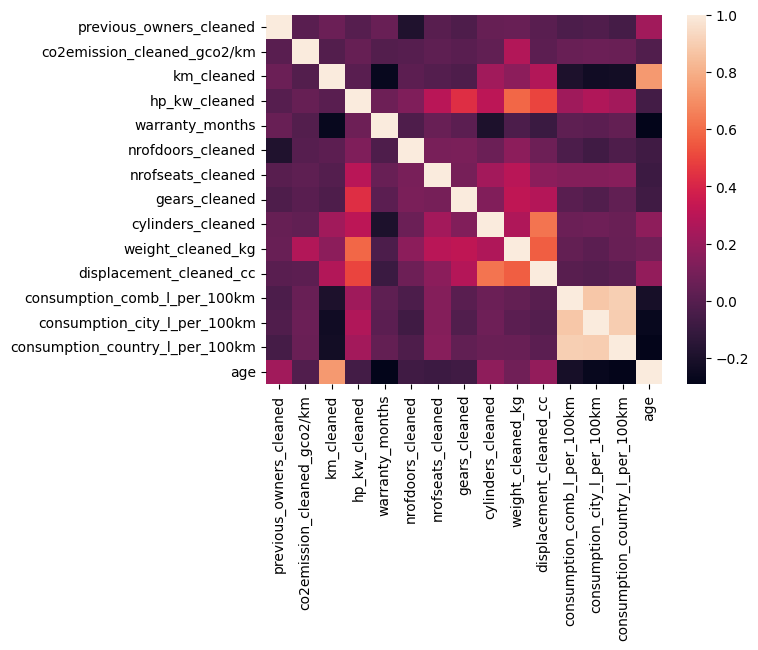

In [446]:
# Select only numeric columns
numeric_cols = df.non_enc_cols.select_dtypes(include=[np.number])

# Generate the correlation matrix for these numeric columns
corr_matrix = numeric_cols.corr()

# Pass the correlation matrix to sns.heatmap()
sns.heatmap(corr_matrix)
# heatmap of correlations for numeric cols (includes numeric categorical variables like age)

## Try to impute mvs for the cateegorical variables first, then can use these wi groupbys to calculate groped medians for filling the numeric variables

Question: is it a potential issue (e.g. compounding error) to use the filled versions as grouping variables for imputation of other columns??

## type_cleaned column 

In [447]:
df['type_cleaned'].isna().sum()

np.int64(2)

In [448]:
df['type_cleaned_filled'] = df['type_cleaned'].fillna(df['type_cleaned'].mode()[0]) 
df['type_cleaned_filled'].value_counts(dropna = False)

type_cleaned_filled
Used              11098
New                1650
Pre-registered     1364
Employee's car     1011
Demonstration       796
Name: count, dtype: int64

Only 2 missig values, fill with the mode of the column

## previous_owners_cleaned

<Axes: xlabel='previous_owners_cleaned', ylabel='Count'>

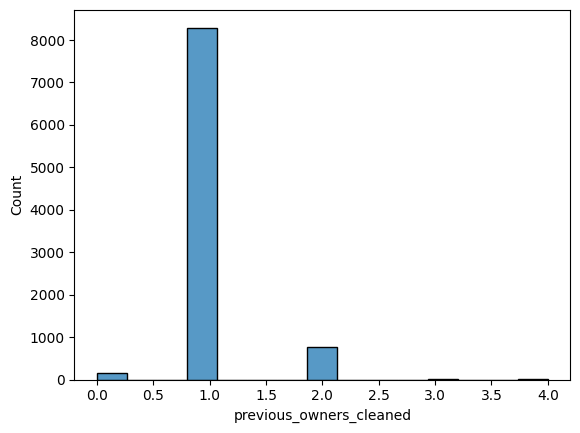

In [449]:
# Look at the distribution of values
sns.histplot(df['previous_owners_cleaned'])

Looks like nans might just be previous_owners = 0, 0s look underrepresented in the data

In [450]:
# compare distribution of nan and values in whether car is new or not
poc_nan = df[df['previous_owners_cleaned'].isna()]
poc_vals = df[~df['previous_owners_cleaned'].isna()]

In [451]:
poc_nan['type_cleaned_filled'].value_counts(dropna = False) # Nearly all the 'New' cars (1496 out of 1650) are in the nans.

type_cleaned_filled
Used              4012
New               1496
Pre-registered     519
Employee's car     356
Demonstration      282
Name: count, dtype: int64

In [452]:
poc_vals['type_cleaned_filled'].value_counts(dropna = False) 

type_cleaned_filled
Used              7086
Pre-registered     845
Employee's car     655
Demonstration      514
New                154
Name: count, dtype: int64

In [453]:
# fill nans using info from 'age' and 'type_cleaned_filled' columns
mode_poc = df.groupby(['type_cleaned_filled'])['previous_owners_cleaned'].transform(lambda x: x.mode().iloc[0])
df['previous_owners_cleaned_filled'] = df['previous_owners_cleaned'].fillna(mode_poc)
df['previous_owners_cleaned_filled'].value_counts(dropna = False)

previous_owners_cleaned_filled
1.0    13463
0.0     1659
2.0      778
3.0       17
4.0        2
Name: count, dtype: int64

## Body cleaned

In [454]:
df['body_cleaned'].value_counts(dropna = False)

body_cleaned
Sedans           7903
Station wagon    3553
Compact          3153
Van               783
Other             290
Transporter        88
NaN                60
Off-Road           56
Coupe              25
Convertible         8
Name: count, dtype: int64

In [455]:
# make_model probably most important grouping variable, use this to fill body
mode_body = df.groupby('make_model')['body_cleaned'].transform(lambda x: x.mode().iloc[0]) # Choose the first modal value of the group
df['body_cleaned_filled'] = df['body_cleaned'].fillna(mode_body)

## Age column

In [456]:
print(df.age.value_counts(dropna = False))

age
1.0    4522
3.0    3674
2.0    3273
0.0    2853
NaN    1597
Name: count, dtype: int64


In [457]:
# Fill age column on basis of type_cleaned (also make_model, km_cleaned?)
age_mode = df.groupby(['make_model','type_cleaned_filled'])['age'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan) # check if there is a mode, may not be if value unique/all 'age' values are nan in that grouping
df['age_filled'] = df['age'].fillna(age_mode)
print(df.age_filled.value_counts(dropna = False))


age_filled
1.0    4540
0.0    4393
3.0    3692
2.0    3276
NaN      18
Name: count, dtype: int64


In [458]:
# Fill the remaining 18 nans with a higher grouping, just type_cleaned_filled in this case
remaining_age_mode = df.groupby(['type_cleaned_filled'])['age'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan) 
df['age_filled'] = df['age_filled'].fillna(remaining_age_mode)
print(df.age_filled.value_counts(dropna = False))

age_filled
1.0    4540
0.0    4411
3.0    3692
2.0    3276
Name: count, dtype: int64


## co2_emission_cleaned

In [459]:
df['gearingtype_cleaned'].value_counts(dropna = False)

gearingtype_cleaned
Manual            8153
Automatic         7297
Semi-automatic     469
Name: count, dtype: int64

In [460]:
df['fuel_cleaned'].value_counts(dropna = False)

fuel_cleaned
diesel      7298
super95     4466
gasoline    3731
other        424
Name: count, dtype: int64

In [461]:
df.emissionclass_cleaned.value_counts(dropna = False)              

emissionclass_cleaned
6      10139
NaN     3628
6d      1907
6c       127
5         78
4         40
Name: count, dtype: int64

In [462]:
median_co2 = df.groupby(['make_model', 'fuel_cleaned','gearingtype_cleaned'])['co2emission_cleaned_gco2/km'].transform(lambda x: x.median())
df['co2emission_cleaned_filled'] = df['co2emission_cleaned_gco2/km'].fillna(median_co2)

c:\Users\BalintStewart\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\BalintStewart\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [463]:
df['co2emission_cleaned_filled'].isna().sum()

np.int64(2)

In [464]:
# Have 2 leftover nas (no median for that grouping), group by higher grouping and impute based on this. make_model probably most important, start with this
median_co2_leftover = df.groupby(['make_model'])['co2emission_cleaned_gco2/km'].transform(lambda x: x.median())
df['co2emission_cleaned_filled'] = df['co2emission_cleaned_filled'].fillna(median_co2_leftover)
df['co2emission_cleaned_filled'].isna().sum()

c:\Users\BalintStewart\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


np.int64(1)

In [465]:
# Have 1 leftover nas (no median for that grouping), group by higher grouping and impute based on this. make_model probably most important, start with this
median_co2_leftover2 = df.groupby(['fuel_cleaned'])['co2emission_cleaned_gco2/km'].transform(lambda x: x.median())
df['co2emission_cleaned_filled'] = df['co2emission_cleaned_filled'].fillna(median_co2_leftover2)
df['co2emission_cleaned_filled'].isna().sum()

np.int64(0)

In [466]:
## emission_class column

In [467]:
mode_emissionclass = df.groupby(['make_model', 'fuel_cleaned'])['emissionclass_cleaned'].transform(lambda x: x.mode().iloc[0])
df['emissionclass_cleaned_filled'] = df['emissionclass_cleaned'].fillna(mode_emissionclass)

In [468]:
df['emissionclass_cleaned_filled'].value_counts(dropna= False)

emissionclass_cleaned_filled
6     13746
6d     1926
6c      127
5        78
4        42
Name: count, dtype: int64

## km_cleaned column

In [469]:
median_group_km = df.groupby(['make_model','body_cleaned_filled','age_filled'])['km_cleaned'].transform(lambda x: x.median()) 

df['km_cleaned_filled'] = df['km_cleaned'].fillna(median_group_km)
df['km_cleaned_filled'].isna().sum()

c:\Users\BalintStewart\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\BalintStewart\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


np.int64(4)

In [470]:
# 4 missing values left, use just make_model and age_filled instead
leftover_median_group_km = df.groupby(['make_model','age_filled'])['km_cleaned'].transform(lambda x: x.median()) 

df['km_cleaned_filled'] = df['km_cleaned_filled'].fillna(leftover_median_group_km)
df['km_cleaned_filled'].isna().sum()


np.int64(0)

In [471]:
# Drop some columns that now have filled versions
df.drop(['previous_owners_cleaned', 'type_cleaned','age', 'km_cleaned','emissionclass_cleaned','co2emission_cleaned_gco2/km','body_cleaned','type_cleaned',
         'previous_owners_cleaned'], axis = 1, inplace = True)

In [472]:
# Determine columns with missing values
cols_with_mv = df.columns[df.isna().sum() > 0]
print(sorted(cols_with_mv))

['bodycolor_cleaned', 'consumption_city_l_per_100km', 'consumption_comb_l_per_100km', 'consumption_country_l_per_100km', 'countryversion_cleaned', 'cylinders_cleaned', 'displacement_cleaned_cc', 'drivechain_cleaned', 'emissionlabel_cleaned', 'gears_cleaned', 'hp_kw_cleaned', 'interior_colour', 'interior_material', 'modelcode_cleaned', 'nextinspection_cleaned', 'nrofdoors_cleaned', 'nrofseats_cleaned', 'offernumber_cleaned', 'painttype_cleaned', 'vat_cleaned', 'warranty_months', 'weight_cleaned_kg', 'year']


Cols with missing values left to impute
['bodycolor_cleaned', 'consumption_city_l_per_100km', 'consumption_comb_l_per_100km', 'consumption_country_l_per_100km', 'countryversion_cleaned', 'cylinders_cleaned', 'displacement_cleaned_cc', 'drivechain_cleaned', 'emissionlabel_cleaned', 'gears_cleaned', 'hp_kw_cleaned', 'interior_colour', 'interior_material', 'modelcode_cleaned', 'nextinspection_cleaned', 'nrofdoors_cleaned', 'nrofseats_cleaned', 'offernumber_cleaned', 'painttype_cleaned', 'vat_cleaned', 'warranty_months', 'weight_cleaned_kg', 'year']

## emissionlabel_cleaned

In [473]:
df[['emissionclass_cleaned_filled','emissionlabel_cleaned']].value_counts(dropna = False)

emissionclass_cleaned_filled  emissionlabel_cleaned
6                             NaN                      10721
                              Green                     2696
6d                            NaN                       1054
                              Green                      811
6                             No sticker                 319
6c                            NaN                         93
5                             NaN                         67
6d                            No sticker                  60
4                             NaN                         39
6c                            Green                       34
5                             Green                        9
6                             Blue                         8
4                             Green                        3
5                             No sticker                   2
6                             Red                          1
                              Yel

In [474]:
mode_emissionlabel = df.groupby(['emissionclass_cleaned_filled'])['emissionlabel_cleaned'].transform(lambda x: x.mode().iloc[0])
df['emissionlabel_cleaned_filled'] = df['emissionlabel_cleaned'].fillna(mode_emissionlabel)
df['emissionlabel_cleaned_filled'].value_counts(dropna = False)

emissionlabel_cleaned_filled
Green         15527
No sticker      381
Blue              8
Yellow            2
Red               1
Name: count, dtype: int64

## bodycolor_cleaned

In [475]:
df['bodycolor_cleaned'].value_counts(dropna = False)

bodycolor_cleaned
Black     3745
Grey      3505
White     3406
Silver    1647
Blue      1431
Red        957
NaN        597
Brown      289
Green      154
Beige      108
Yellow      51
Violet      18
Bronze       6
Orange       3
Gold         2
Name: count, dtype: int64

In [476]:
mode_bodycolor = df.groupby(['make_model','body_cleaned_filled'])['bodycolor_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['bodycolor_cleaned_filled'] = df['bodycolor_cleaned'].fillna(mode_bodycolor)
df['bodycolor_cleaned_filled'].value_counts(dropna = False)

bodycolor_cleaned_filled
Black     3941
Grey      3836
White     3469
Silver    1647
Blue      1431
Red        957
Brown      289
Green      158
Beige      108
Yellow      51
Violet      18
Bronze       6
Orange       3
NaN          3
Gold         2
Name: count, dtype: int64

In [477]:
# groupby make_model only now
mode_bodycolor2 = df.groupby(['make_model'])['bodycolor_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['bodycolor_cleaned_filled'] = df['bodycolor_cleaned_filled'].fillna(mode_bodycolor2)
df['bodycolor_cleaned_filled'].value_counts(dropna = False)

bodycolor_cleaned_filled
Black     3941
Grey      3839
White     3469
Silver    1647
Blue      1431
Red        957
Brown      289
Green      158
Beige      108
Yellow      51
Violet      18
Bronze       6
Orange       3
Gold         2
Name: count, dtype: int64

## painttype_cleaned

In [478]:
df['painttype_cleaned'].value_counts(dropna = False)

painttype_cleaned
Metallic       9794
NaN            5772
Uni/basic       347
Perl effect       6
Name: count, dtype: int64

In [479]:
mode_painttype = df.groupby(['make_model','bodycolor_cleaned_filled'])['painttype_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['painttype_cleaned_filled'] = df['painttype_cleaned'].fillna(mode_painttype)
df['painttype_cleaned_filled'].value_counts(dropna = False)

painttype_cleaned_filled
Metallic       15536
Uni/basic        364
NaN               11
Perl effect        8
Name: count, dtype: int64

In [480]:
# groupby make_model only now to impute the remaining 11 missing values
mode_painttype2 = df.groupby(['make_model'])['painttype_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['painttype_cleaned_filled'] = df['painttype_cleaned_filled'].fillna(mode_painttype2)
df['painttype_cleaned_filled'].value_counts(dropna = False)

painttype_cleaned_filled
Metallic       15547
Uni/basic        364
Perl effect        8
Name: count, dtype: int64

In [481]:
# compare value counts of body and make_model
df[['body_cleaned_filled','make_model']].value_counts(dropna= False)

body_cleaned_filled  make_model    
Sedans               Audi A3           2605
Station wagon        Opel Insignia     1614
Sedans               Audi A1           1538
Compact              Opel Corsa        1232
Station wagon        Opel Astra        1218
Sedans               Opel Astra        1053
Compact              Audi A1           1039
Sedans               Renault Clio       933
                     Opel Insignia      900
                     Opel Corsa         875
Van                  Renault Espace     803
Compact              Renault Clio       484
Station wagon        Renault Clio       337
                     Audi A3            282
Compact              Opel Astra         185
                     Audi A3            182
Station wagon        Renault Espace      91
Other                Opel Corsa          87
                     Opel Astra          67
Transporter          Renault Espace      52
Other                Renault Clio        51
                     Opel Insignia      

## nr of seats cleaned

In [482]:
mode_nrofseats = df.groupby(['make_model','body_cleaned_filled'])['nrofseats_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['nrofseats_cleaned_filled'] = df['nrofseats_cleaned'].fillna(mode_nrofseats)
df['nrofseats_cleaned_filled'].value_counts(dropna = False)

nrofseats_cleaned_filled
5.0    14302
4.0     1127
7.0      362
2.0      119
NaN        6
6.0        2
3.0        1
Name: count, dtype: int64

In [483]:
# groupby make_model only now to impute the remaining 6 missing values
mode_nrofseats2 = df.groupby(['make_model'])['nrofseats_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['nrofseats_cleaned_filled'] = df['nrofseats_cleaned_filled'].fillna(mode_nrofseats2)
df['nrofseats_cleaned_filled'].value_counts(dropna = False)

nrofseats_cleaned_filled
5.0    14308
4.0     1127
7.0      362
2.0      119
6.0        2
3.0        1
Name: count, dtype: int64

## nrofdoors_cleaned

In [484]:
mode_nrofdoors = df.groupby(['make_model','body_cleaned_filled'])['nrofdoors_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['nrofdoors_cleaned_filled'] = df['nrofdoors_cleaned'].fillna(mode_nrofdoors)
df['nrofdoors_cleaned_filled'].value_counts(dropna = False)

nrofdoors_cleaned_filled
5.0    11785
4.0     3079
3.0      832
2.0      219
NaN        2
1.0        1
7.0        1
Name: count, dtype: int64

In [485]:
# groupby make_model only now to impute the remaining 2 missing values
mode_nrofdoors2 = df.groupby(['make_model'])['nrofdoors_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['nrofdoors_cleaned_filled'] = df['nrofdoors_cleaned_filled'].fillna(mode_nrofdoors2)
df['nrofdoors_cleaned_filled'].value_counts(dropna = False)

nrofdoors_cleaned_filled
5.0    11787
4.0     3079
3.0      832
2.0      219
1.0        1
7.0        1
Name: count, dtype: int64

## countryversion_cleaned

In [486]:
pd.set_option('display.max_rows', 100)
df[['make_model','countryversion_cleaned']].value_counts(dropna = False)


make_model      countryversion_cleaned
Audi A3         NaN                       1880
Audi A1         NaN                       1400
Opel Astra      NaN                       1297
Opel Insignia   NaN                       1204
Opel Corsa      NaN                       1017
Renault Clio    NaN                        990
Opel Insignia   Germany                    974
Opel Astra      Germany                    840
Opel Corsa      Germany                    840
Audi A1         Germany                    767
Renault Espace  NaN                        520
Renault Clio    Germany                    457
Audi A3         Germany                    379
                Italy                      353
Renault Espace  Germany                    244
Audi A3         European Union             219
Opel Corsa      Italy                      176
Audi A1         Italy                      156
Opel Insignia   Netherlands                141
Renault Clio    Italy                      125
Opel Astra      Italy

Doesn't look like make_model is an especially good predictor (e.g. Audi A3 equally likely to be Germany or Italy), can we impute 'unknown_country' to replace nan as its own category? Or else drop this feature...

In [487]:
df['countryversion_cleaned_filled'] = df['countryversion_cleaned'].fillna('Unknown_country')
df['countryversion_cleaned_filled'].value_counts(dropna = False)

countryversion_cleaned_filled
Unknown_country    8333
Germany            4502
Italy              1038
European Union      507
Netherlands         464
Spain               325
Belgium             314
Austria             208
Czech Republic       52
Poland               49
France               38
Denmark              33
Hungary              28
Japan                 8
Croatia               4
Slovakia              4
Sweden                3
Bulgaria              2
Romania               2
Switzerland           1
Luxembourg            1
Slovenia              1
Serbia                1
Egypt                 1
Name: count, dtype: int64

In [488]:
pd.set_option('display.max_rows', None)
df['modelcode_cleaned'].value_counts(dropna = False)

modelcode_cleaned
NaN         10941
0035/BCB      268
0588/BNO      245
0588/BDB      206
0588/BHX      188
1844/ADJ      175
0588/BDF      175
0588/BCV      139
3333/BAJ      122
3333/BEF      118
0588/AYB      117
0035/BEL      111
0588/BLL      109
3333/BHJ       87
0588/BLH       86
0035/BFM       84
0035/BKN       84
0588/AWJ       82
3333/BJR       79
0588/BHM       79
0035/BFI       76
0035/BKQ       69
0588/BDC       67
0035/BKU       62
0035/BHM       60
0035/BBZ       59
3333/BDQ       59
0588/BNN       58
0588/BLG       53
0588/BDG       52
3333/BEG       50
0035/BHQ       48
0035/BCJ       46
0035/BFP       44
1844/AJG       43
0035/BHP       43
0035/BHY       41
0588/BHL       40
0035/BFJ       39
0035/BCL       38
0588/BCZ       35
0588/BIB       35
1844/ACW       35
0035/BGP       35
1844/ACP       32
1844/AAI       32
0588/BCW       31
1844/AAK       30
0035/BKM       29
0035/BBU       28
0035/BKY       27
0035/BHZ       26
1844/AEV       24
0035/BKR       23
3333/BAU  

In [489]:
pd.set_option('display.max_rows', None)
df[['make_model','modelcode_cleaned']].value_counts(dropna = False)

make_model      modelcode_cleaned
Audi A3         NaN                  2293
Opel Insignia   NaN                  1813
Opel Astra      NaN                  1749
Opel Corsa      NaN                  1463
Audi A1         NaN                  1434
Renault Clio    NaN                  1385
Renault Espace  NaN                   770
Opel Corsa      0035/BCB              268
Audi A1         0588/BNO              245
                0588/BDB              206
Audi A3         0588/BHX              188
Audi A1         0588/BDF              175
Opel Corsa      1844/ADJ              175
Audi A1         0588/BCV              139
Renault Clio    3333/BAJ              122
                3333/BEF              118
Audi A3         0588/AYB              117
Opel Insignia   0035/BEL              111
Audi A3         0588/BLL              109
Renault Espace  3333/BHJ               87
Audi A3         0588/BLH               86
Opel Astra      0035/BFM               84
Audi A3         0588/AWJ               82


Seems like modelcode isn't a very useful feature here, lots of missing values difficult to impute on information we already have. Suggest we drop entirely

In [490]:
df.drop('modelcode_cleaned', axis = 1, inplace = True)

## vat_cleaned column

In [491]:
df['vat_cleaned'].value_counts(dropna = False)

vat_cleaned
VAT deductible      10980
NaN                  4513
Price negotiable      426
Name: count, dtype: int64

In this case, nan refers to 'VAT nondeductible'. Replace with this 

In [492]:
df['vat_cleaned_filled'] = df['vat_cleaned'].fillna('VAT nondeductible')
df['vat_cleaned_filled'].value_counts(dropna = False)

vat_cleaned_filled
VAT deductible       10980
VAT nondeductible     4513
Price negotiable       426
Name: count, dtype: int64

 ## cylinders_cleaned

In [493]:
df['cylinders_cleaned'].value_counts(dropna=False)

cylinders_cleaned
4.0    8105
NaN    5680
3.0    2104
5.0      22
6.0       3
8.0       2
2.0       2
1.0       1
Name: count, dtype: int64

In [494]:
mode_cylinders_cleaned = df.groupby(['make_model','body_cleaned_filled','fuel_cleaned'])['cylinders_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['cylinders_cleaned_filled'] = df['cylinders_cleaned'].fillna(mode_cylinders_cleaned)
df['cylinders_cleaned_filled'].value_counts(dropna = False)

cylinders_cleaned_filled
4.0    12533
3.0     3335
5.0       22
NaN       21
6.0        3
8.0        2
2.0        2
1.0        1
Name: count, dtype: int64

In [495]:
# groupby make_model only for remaining 21 NaNs
mode_cylinders_cleaned2 = df.groupby(['make_model'])['cylinders_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['cylinders_cleaned_filled'] = df['cylinders_cleaned_filled'].fillna(mode_cylinders_cleaned2)
df['cylinders_cleaned_filled'].value_counts(dropna = False)

cylinders_cleaned_filled
4.0    12549
3.0     3339
5.0       22
6.0        3
2.0        2
8.0        2
NaN        1
1.0        1
Name: count, dtype: int64

In [496]:
# groupby 'body_cleaned_filled' only for remaining 1 NaNs
mode_cylinders_cleaned3 = df.groupby(['body_cleaned_filled'])['cylinders_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['cylinders_cleaned_filled'] = df['cylinders_cleaned_filled'].fillna(mode_cylinders_cleaned3)
df['cylinders_cleaned_filled'].value_counts(dropna = False)

cylinders_cleaned_filled
4.0    12550
3.0     3339
5.0       22
6.0        3
8.0        2
2.0        2
1.0        1
Name: count, dtype: int64

## gears_cleaned

In [497]:
df['gears_cleaned'].value_counts(dropna= False)

gears_cleaned
6.0     5822
NaN     4712
5.0     3239
7.0     1908
8.0      224
9.0        6
1.0        2
4.0        2
3.0        2
2.0        1
50.0       1
Name: count, dtype: int64

In [498]:
# Groupby categories likely to be important in number of gears
mode_gears_cleaned = df.groupby(['make_model','body_cleaned_filled','fuel_cleaned'])['gears_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['gears_cleaned_filled'] = df['gears_cleaned'].fillna(mode_cylinders_cleaned)
df['gears_cleaned_filled'].value_counts(dropna = False)

gears_cleaned_filled
6.0     5822
4.0     3415
5.0     3239
7.0     1908
3.0     1287
8.0      224
NaN       14
9.0        6
1.0        2
2.0        1
50.0       1
Name: count, dtype: int64

In [499]:
# groupby only make_model for final 14 missing values
mode_gears_cleaned2 = df.groupby(['make_model'])['gears_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['gears_cleaned_filled'] = df['gears_cleaned_filled'].fillna(mode_cylinders_cleaned2)
df['gears_cleaned_filled'].value_counts(dropna = False)

gears_cleaned_filled
6.0     5822
4.0     3427
5.0     3239
7.0     1908
3.0     1288
8.0      224
9.0        6
1.0        2
NaN        1
2.0        1
50.0       1
Name: count, dtype: int64

In [500]:
# groupby only 'body_cleaned_filled' for final 1 missing values
mode_gears_cleaned3 = df.groupby(['body_cleaned_filled'])['gears_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['gears_cleaned_filled'] = df['gears_cleaned_filled'].fillna(mode_cylinders_cleaned3)
df['gears_cleaned_filled'].value_counts(dropna = False)

gears_cleaned_filled
6.0     5822
4.0     3428
5.0     3239
7.0     1908
3.0     1288
8.0      224
9.0        6
1.0        2
2.0        1
50.0       1
Name: count, dtype: int64

## interior_material

In [501]:
df[['interior_material','interior_colour']].value_counts(dropna = False)

interior_material  interior_colour
Cloth              Black              5821
NaN                NaN                3720
Part leather       Black              1121
Cloth              NaN                1005
                   Grey                891
                   Other               639
Full leather       Black               575
NaN                Black               491
                   Grey                273
Other              Other               182
Part leather       NaN                 140
Full leather       NaN                 139
Part leather       Grey                116
Full leather       Brown               116
Other              Black               110
Full leather       Other                72
                   Grey                 67
Part leather       Other                65
Other              NaN                  56
Part leather       Brown                50
alcantara          Black                47
Velour             Black                36
Full leather       

In [502]:
# Groupby categories likely to affect interior design
mode_interior_material = df.groupby(['make_model','body_cleaned_filled'])['interior_material'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['interior_material_filled'] = df['interior_material'].fillna(mode_interior_material)
df['interior_material_filled'].value_counts(dropna = False)

interior_material_filled
Cloth           12457
Part leather     1552
Full leather     1380
Other             404
Velour             60
alcantara          57
NaN                 9
Name: count, dtype: int64

In [503]:
mode_interior_material2 = df.groupby(['make_model'])['interior_material'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['interior_material_filled'] = df['interior_material_filled'].fillna(mode_interior_material2)
df['interior_material_filled'].value_counts(dropna = False)

interior_material_filled
Cloth           12464
Part leather     1552
Full leather     1382
Other             404
Velour             60
alcantara          57
Name: count, dtype: int64

## interior colour


In [504]:
df['interior_colour'].value_counts(dropna = False)

interior_colour
Black     8201
NaN       5078
Grey      1376
Other      960
Brown      207
Beige       54
Blue        16
White       13
Red          9
Yellow       4
Orange       1
Name: count, dtype: int64

In [505]:
# Groupby categories likely to affect interior design
mode_interior_colour = df.groupby(['make_model','body_cleaned_filled'])['interior_colour'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['interior_colour_filled'] = df['interior_colour'].fillna(mode_interior_colour)
df['interior_colour_filled'].value_counts(dropna = False)

interior_colour_filled
Black     13156
Grey       1442
Other       961
Brown       248
Beige        55
Blue         16
NaN          14
White        13
Red           9
Yellow        4
Orange        1
Name: count, dtype: int64

In [506]:
# widen the grouping to fill last remaining 14 missing values
mode_interior_colour2 = df.groupby(['make_model'])['interior_colour'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['interior_colour_filled'] = df['interior_colour_filled'].fillna(mode_interior_colour2)
df['interior_colour_filled'].value_counts(dropna = False)

interior_colour_filled
Black     13170
Grey       1442
Other       961
Brown       248
Beige        55
Blue         16
White        13
Red           9
Yellow        4
Orange        1
Name: count, dtype: int64

## waranty_months

In [507]:
df['warranty_months'].value_counts(dropna = False)

warranty_months
NaN     11066
12.0     2594
24.0     1118
60.0      401
36.0      279
48.0      149
6.0       125
72.0       59
3.0        33
23.0       11
18.0       10
20.0        7
25.0        6
2.0         5
50.0        4
26.0        4
16.0        4
19.0        3
34.0        3
4.0         3
1.0         3
13.0        3
22.0        2
28.0        2
11.0        2
46.0        2
9.0         2
21.0        2
14.0        2
45.0        2
17.0        2
47.0        1
49.0        1
56.0        1
10.0        1
7.0         1
8.0         1
15.0        1
65.0        1
33.0        1
40.0        1
30.0        1
Name: count, dtype: int64

In this case, warranty_months nan refer to cars without any warranty. Replace NaNs with 0

In [508]:
df['warranty_months_filled'] = df['warranty_months'].fillna(0)
df['warranty_months_filled'].value_counts(dropna = False)

warranty_months_filled
0.0     11066
12.0     2594
24.0     1118
60.0      401
36.0      279
48.0      149
6.0       125
72.0       59
3.0        33
23.0       11
18.0       10
20.0        7
25.0        6
2.0         5
50.0        4
26.0        4
16.0        4
19.0        3
34.0        3
4.0         3
1.0         3
13.0        3
22.0        2
28.0        2
11.0        2
46.0        2
9.0         2
21.0        2
14.0        2
45.0        2
17.0        2
47.0        1
49.0        1
56.0        1
10.0        1
7.0         1
8.0         1
15.0        1
65.0        1
33.0        1
40.0        1
30.0        1
Name: count, dtype: int64

## offernumber_cleaned

In [509]:
df['offernumber_cleaned'].value_counts(dropna = False)

offernumber_cleaned
NaN                                                  3175
XT61649                                                27
HM53619                                                27
XJ38068                                                27
JV03654                                                27
AK13780                                                27
LT67679                                                27
TA76392                                                27
TP62881                                                27
UN89904                                                27
BA804713                                               19
BR727019                                               19
BA863083                                               19
BA344433                                               19
BA375295                                               18
REF_100733                                             15
A17001                                              

Doesn't look like this feature has useful information, many many unique values. Suggest we drop

In [510]:
df.drop('offernumber_cleaned', axis = 1, inplace = True)

## nextinspection_cleaned

In [511]:
df['nextinspection_cleaned'].value_counts(dropna = False)

nextinspection_cleaned
NaN           15209
2022-04-01       62
2021-03-01       38
2022-03-01       36
2021-06-01       34
2022-01-01       32
2021-04-01       29
2021-05-01       27
2022-05-01       27
2020-03-01       25
2019-05-01       23
2023-01-01       19
2021-02-01       19
2020-02-01       18
2021-09-01       17
2022-02-01       16
2020-04-01       16
2021-01-01       15
2020-01-01       15
2022-06-01       14
2020-07-01       13
2019-07-01       13
2019-04-01       13
2020-11-01       12
2020-05-01       12
2023-02-01       10
2019-09-01        9
2020-06-01        8
2023-03-01        8
2021-07-01        8
2022-08-01        8
2019-03-01        8
2022-07-01        7
2019-12-01        7
2019-08-01        7
2019-06-01        7
2020-08-01        6
2020-09-01        6
2019-11-01        6
2018-10-01        5
2021-08-01        5
2021-10-01        4
2018-12-01        4
2019-10-01        4
2019-02-01        4
2020-12-01        3
2020-10-01        3
2017-03-01        3
2023-04-01       

nextinspection has many missing values, lots of unique values. Could maybe keep 'year' only, and impute using 'age', but not enough useful info here to keep. Suggest we drop this column

In [512]:
df.drop('nextinspection_cleaned',axis = 1, inplace = True)

## 'drivechain_cleaned'

In [513]:
df['drivechain_cleaned'].value_counts(dropna = False)

drivechain_cleaned
front    8886
NaN      6858
4WD       171
rear        4
Name: count, dtype: int64

In [514]:
# Groupby categories likely to affect drivechain
mode_drivechain_cleaned = df.groupby(['make_model','body_cleaned_filled'])['drivechain_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['drivechain_cleaned_filled'] = df['drivechain_cleaned'].fillna(mode_drivechain_cleaned)
df['drivechain_cleaned_filled'].value_counts(dropna = False)

drivechain_cleaned_filled
front    15699
4WD        204
NaN         12
rear         4
Name: count, dtype: int64

In [515]:
# Groupby higher category make_model only to impute remaining 12 nans
mode_drivechain_cleaned2 = df.groupby(['make_model'])['drivechain_cleaned'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['drivechain_cleaned_filled'] = df['drivechain_cleaned_filled'].fillna(mode_drivechain_cleaned2)
df['drivechain_cleaned_filled'].value_counts(dropna = False)

drivechain_cleaned_filled
front    15711
4WD        204
rear         4
Name: count, dtype: int64

## displacement_cleaned_cc

In [516]:
df['displacement_cleaned_cc'].value_counts(dropna= False)

displacement_cleaned_cc
1598.0     4761
999.0      2438
1398.0     1314
1399.0      749
1229.0      677
1956.0      670
1461.0      595
1490.0      559
NaN         496
1422.0      467
1197.0      353
898.0       351
1395.0      320
1968.0      301
1149.0      288
1618.0      212
1798.0      210
1498.0      196
1600.0      130
1248.0      110
1997.0      103
1364.0      102
1400.0       90
998.0        72
1500.0       50
2000.0       46
1000.0       40
1.0          36
1998.0       25
2480.0       20
1200.0       18
1984.0       18
899.0        11
1397.0       11
160.0         6
1499.0        5
929.0         5
1596.0        4
997.0         4
900.0         4
139.0         4
1396.0        3
1199.0        3
1599.0        3
995.0         2
1495.0        2
1589.0        2
1300.0        2
2.0           2
1369.0        1
15898.0       1
1350.0        1
1239.0        1
973.0         1
1696.0        1
1896.0        1
1584.0        1
996.0         1
1568.0        1
1686.0        1
1368.0        1


<Axes: >

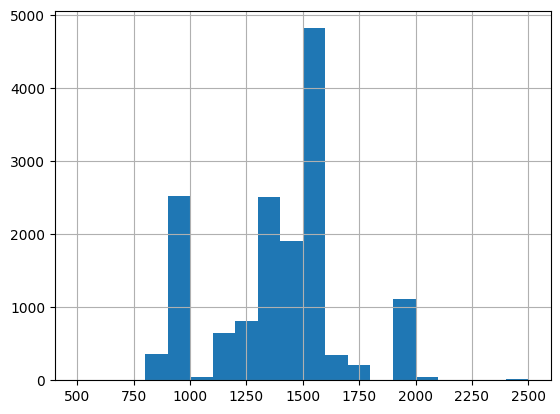

In [517]:
df['displacement_cleaned_cc'].hist(bins = 20, range = (500,2500))

In [518]:
median_displacement = df.groupby(['make_model', 'fuel_cleaned'])['displacement_cleaned_cc'].transform(lambda x: x.median())
df['displacement_cleaned_filled'] = df['displacement_cleaned_cc'].fillna(median_displacement)
df['displacement_cleaned_filled'].isna().sum()

np.int64(0)

## hp_kw_cleaned

In [519]:
df['hp_kw_cleaned'].value_counts(dropna = False)

hp_kw_cleaned
85.0     2542
66.0     2122
81.0     1402
100.0    1308
110.0    1112
70.0      888
125.0     707
51.0      695
55.0      569
118.0     516
92.0      466
121.0     392
147.0     380
77.0      345
56.0      286
54.0      276
103.0     253
87.0      232
165.0     194
88.0      177
60.0      160
162.0      98
NaN        88
74.0       81
96.0       72
71.0       59
101.0      47
67.0       40
154.0      39
122.0      35
119.0      30
164.0      27
135.0      24
52.0       22
82.0       22
78.0       20
1.0        20
146.0      18
294.0      18
141.0      16
57.0       10
120.0       8
104.0       8
191.0       7
112.0       7
155.0       6
117.0       6
184.0       5
76.0        4
65.0        4
90.0        4
93.0        3
149.0       3
80.0        3
98.0        3
168.0       3
86.0        2
140.0       2
270.0       2
228.0       2
150.0       2
127.0       2
143.0       2
63.0        2
40.0        2
167.0       2
53.0        2
89.0        2
84.0        1
132.0       1
137.0 

<Axes: >

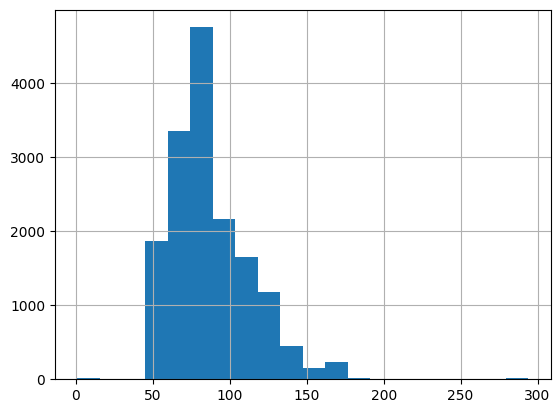

In [520]:
df['hp_kw_cleaned'].hist(bins = 20)

horsepower could be influenced by make model, type of fuel, and gearing type. Also directly related to displacement? Group by these and calculate median

In [521]:
median_hp_kw = df.groupby([
    'make_model',
    'fuel_cleaned',
    'displacement_cleaned_filled',
    'gearingtype_cleaned'
])['hp_kw_cleaned'].transform(lambda x: x.median())

df['hp_kw_cleaned_filled'] = df['hp_kw_cleaned'].fillna(median_hp_kw)
df['hp_kw_cleaned_filled'].isna().sum()

c:\Users\BalintStewart\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\BalintStewart\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


np.int64(9)

In [522]:
# fill remaining 9 nans with displacement_cleaned_filled only
median_hp_kw2 = df.groupby([
    'displacement_cleaned_filled',
])['hp_kw_cleaned'].transform(lambda x: x.median())
df['hp_kw_cleaned_filled'] = df['hp_kw_cleaned_filled'].fillna(median_hp_kw2)
df['hp_kw_cleaned_filled'].isna().sum()

np.int64(0)

## weight_cleaned_kg

In [523]:
df['weight_cleaned_kg'].isna().sum()

np.int64(6974)

In [524]:
# groupby factors affecting weight most obviously
median_weight = df.groupby([
    'make_model',
    'body_cleaned_filled',
    'fuel_cleaned',
    'drivechain_cleaned_filled'
])['weight_cleaned_kg'].transform(lambda x: x.median())

df['weight_cleaned_filled'] = df['weight_cleaned_kg'].fillna(median_weight)
df['weight_cleaned_filled'].isna().sum()

c:\Users\BalintStewart\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\BalintStewart\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\BalintStewart\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\BalintStewart\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\BalintStewart\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty sli

np.int64(64)

In [525]:
# broaden the grouping to fill remaining 64 missing values
median_weight2 = df.groupby([
    'body_cleaned_filled'
])['weight_cleaned_kg'].transform(lambda x: x.median())
df['weight_cleaned_filled'] = df['weight_cleaned_filled'].fillna(median_weight2)
df['weight_cleaned_filled'].isna().sum()

np.int64(0)

## consumption city, country, comb

These three are closely related (comb is average of city and country), examine the pattern of missing values across the three columns to see if we can impute based on knowing the values of the other 2 columns (or else if we should only keep the combined consumption column)

In [526]:
# create boolena df indicating missing values
missing_combinations = df[['consumption_city_l_per_100km', 'consumption_comb_l_per_100km', 'consumption_country_l_per_100km']].isnull()
# count the occurances of each combination
missing_patterns = missing_combinations.groupby(['consumption_city_l_per_100km', 'consumption_comb_l_per_100km', 'consumption_country_l_per_100km']).size().reset_index(name='count')
missing_patterns

,consumption_city_l_per_100km,consumption_comb_l_per_100km,consumption_country_l_per_100km,count
0,False,False,False,12497
1,False,False,True,11
2,False,True,False,108
3,True,False,False,52
4,True,False,True,445
5,True,True,False,19
6,True,True,True,2787


In [527]:
# Impute missing values for consumption_comb_l_per_100km where I have both values for the other two by calculating their mean (108 missing values)
df['consumption_comb_l_per_100km'] = df['consumption_comb_l_per_100km'].fillna(
    (df['consumption_city_l_per_100km'] + df['consumption_country_l_per_100km']) / 2
)

Now I have gotten best use out of consumption_city and consumption_country columns, I can drop these, and impute the rest of the missing values from combined column by group-based imputation using medians

In [528]:
df.drop(['consumption_city_l_per_100km', 'consumption_country_l_per_100km'], axis = 1, inplace = True)

In [529]:
median_comb = df.groupby(['make_model', 'fuel_cleaned'])['consumption_comb_l_per_100km'].transform(lambda x: x.median())
df['consumption_comb_filled'] = df['consumption_comb_l_per_100km'].fillna(median_comb)
df['consumption_comb_filled'].isna().sum()

np.int64(0)

In [530]:
# Drop some columns that now have filled versions
df.drop(['nrofseats_cleaned', 'bodycolor_cleaned','emissionlabel_cleaned','nrofdoors_cleaned','painttype_cleaned','countryversion_cleaned','vat_cleaned',
         'interior_material','warranty_months','weight_cleaned_kg','interior_colour','consumption_comb_l_per_100km','cylinders_cleaned','displacement_cleaned_cc',
           'drivechain_cleaned', 'gears_cleaned','hp_kw_cleaned','year'], axis = 1, inplace = True)

In [531]:
df.isna().sum().sort_index()

abs                                      0
adaptive_cruise_control                  0
adaptive_headlights                      0
age_filled                               0
air_conditioning                         0
alarm_system                             0
alloy_wheels                             0
armrest                                  0
automatic_climate_control                0
blind_spot_monitor                       0
bluetooth                                0
body_cleaned_filled                      0
bodycolor_cleaned_filled                 0
catalytic_converter                      0
cd_player                                0
central_door_lock                        0
central_door_lock_with_remote_control    0
co2emission_cleaned_filled               0
comfort_convenience_cleaned              0
consumption_comb_filled                  0
countryversion_cleaned_filled            0
cruise_control                           0
cylinders_cleaned_filled                 0
daytime_run

In [532]:
# save the cleaned filled file as .csv file
df.to_csv('data/clean_filled_auto_scout.csv', index=False)

registration/age columns

TO DO after meeting: fill age using km_cleaned. Look at means and distribution (2std, 95% of data for each one lines), then have cutoffs for each year.
Because some of km_cleaned is null, can't fill all of them. Could use price of car? Better not to. Just assign 2019 to these cars (only 4 of them)

km:
'make_model','body_type','age'['km'].median()[:20]
This will still give us some NAs

Can write a function:
def fill_group(groups)

previous_owners
index=df[df['km']<10.index>]

df.loc[index,'prev_owner']=0.0


type
Directly filled with 'used' (eyeball age/km etc at other columns)

inspection new
NaN 11987
Yes 3932

Fill the NaNs here with 'No'.

cylinders:
make_model, displacement

co2 emissiom:
make_model, displacement

emission_class:
co2emission

drop upholstery material and colour columns?

NEXT steps: look at outlier analysis
This project: mostly misprints? 
Numeric features: boxplots (use make_model on the x axis)
Categorical features: bar plots
Outliers affect model strongly. Drop extreme outliers? There are also methods to 'move' outliers into your range - this is not recommended. In this data we have 16000 obs
Misprints (e.g. hp = 0) - convert to null, and then fill the values. Look at outliers first (e.g. df[df['hp'] <50]). Then convert these to np.nan
haev a look at high outliers (e.g. hp>200), you'll see that these seem 'real' (generally Audi, high price etc). Then fill 

body_color
Make smaller groups (e.g. up to 'Brown') e.g. with value_counts <500, make into a new group called 'other'.

nr doors. those with 1 door are renault cleao. if you look at renault cleo, they always have 4 or 5 doors. So fill accordingly
Change 4 doors to 5 doors, 2 doors to 3 doors (whether you include trunk or not)

nr seats.
Look again at rare types (e.g. 3 seats or 6 seats). See what model they are and infer from that

displacement
got 0 values again. if >x thousand, fill with np.nan, if <600, np.nan (look at these too?)

consumption:
same as displacement

Next week: talk about get_dummies, scaling the data, and linear regression